In [49]:
# Import dependancies
import tweepy
import re
import requests
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import ast
import community
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from fa2 import ForceAtlas2
import networkx.algorithms.community as nx_comm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

The user_id column has to be read as a str:

In [24]:
# Load data
usernames_uk = pd.read_csv("data/canada/files/data_w_usernames_CAN.csv",index_col=0, dtype={'user_id':str})

/Users/huayuan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
usernames_uk = usernames_uk.reset_index(drop = True)

In [26]:
mentions = pd.read_csv("data/canada/files/mentions_CAN.csv", index_col = 0)
mentions = mentions.reset_index(drop=True)

Merging the dataframe that contains only the twitter with at least one mention with the dataframe that contained the scraped usernames

In [27]:
mentions['username'] = pd.merge(mentions, usernames_uk, on = "tweet_ID").iloc[:, -1] 

In [28]:
data_df = mentions

In [29]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1.221960e+18,13752142,wuhan,2020-01-28 00:55:15,0.409,0.468,0.530,0.255,0.462,-1.0,A,@maurerbot @JustinTrudeau There's already What...,28.0,"['maurerbot', 'JustinTrudeau']",StMinaHamilton
1,1.221971e+18,1031691314536935424,wuhan,2020-01-28 01:38:26,0.501,0.473,0.366,0.294,0.367,0.0,NaN,"""Tracking coronavirus: Map, data and timeline""...",16.0,['BNONews'],WalkinRobinL
2,1.221976e+18,31473811,wuhan,2020-01-28 01:57:58,0.451,0.453,0.435,0.336,0.451,-1.0,F,@AliEhsassi we have a Canadian baby and her mo...,34.0,['AliEhsassi'],WillWalkerley
3,1.221985e+18,1072771,wuhan,2020-01-28 02:36:25,0.436,0.526,0.415,0.232,0.379,-1.0,F,3 are currently under observation in Quebec fo...,38.0,['GoogleNews'],Road_Buster84
4,1.221990e+18,401098282,wuhan,2020-01-28 02:53:08,0.501,0.436,0.473,0.351,0.365,0.0,NaN,@Franktmcveety Is this the official site for h...,40.0,['Franktmcveety'],burlingtonlaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229913,1.285832e+18,71669770,covid,2020-07-22 06:59:12,0.468,0.434,0.408,0.325,0.365,-1.0,F,"@Maefrombackeast It saves a lot of time. Plus,...",45.0,['Maefrombackeast'],NaN
229914,1.285832e+18,790757502040305664,covid,2020-07-22 06:59:23,0.603,0.347,0.402,0.487,0.299,1.0,H,@SamTalksTesla @elonmusk This Guy my Sam Frien...,37.0,"['SamTalksTesla', 'elonmusk']",NaN
229915,1.285835e+18,2554092884,covid,2020-07-22 07:10:30,0.516,0.350,0.384,0.337,0.365,0.0,NaN,@gabe_prewitt @TheMeadowlands @eedoogie @Jessi...,36.0,"['gabe_prewitt', 'TheMeadowlands', 'eedoogie',...",NaN
229916,1.285836e+18,1497174692,covid,2020-07-22 07:15:29,0.330,0.604,0.529,0.157,0.545,-1.0,F,@660NEWS People are still getting sick. The vi...,54.0,['660NEWS'],NaN


Removing the rows for which it was not possible to retrieve the usernames:

In [30]:
data_df = data_df.dropna(subset=['username']).reset_index(drop=True)

In [31]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1.221960e+18,13752142,wuhan,2020-01-28 00:55:15,0.409,0.468,0.530,0.255,0.462,-1.0,A,@maurerbot @JustinTrudeau There's already What...,28.0,"['maurerbot', 'JustinTrudeau']",StMinaHamilton
1,1.221971e+18,1031691314536935424,wuhan,2020-01-28 01:38:26,0.501,0.473,0.366,0.294,0.367,0.0,NaN,"""Tracking coronavirus: Map, data and timeline""...",16.0,['BNONews'],WalkinRobinL
2,1.221976e+18,31473811,wuhan,2020-01-28 01:57:58,0.451,0.453,0.435,0.336,0.451,-1.0,F,@AliEhsassi we have a Canadian baby and her mo...,34.0,['AliEhsassi'],WillWalkerley
3,1.221985e+18,1072771,wuhan,2020-01-28 02:36:25,0.436,0.526,0.415,0.232,0.379,-1.0,F,3 are currently under observation in Quebec fo...,38.0,['GoogleNews'],Road_Buster84
4,1.221990e+18,401098282,wuhan,2020-01-28 02:53:08,0.501,0.436,0.473,0.351,0.365,0.0,NaN,@Franktmcveety Is this the official site for h...,40.0,['Franktmcveety'],burlingtonlaw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229545,1.285773e+18,2876869331,covid,2020-07-22 03:07:43,0.504,0.379,0.431,0.378,0.372,0.0,NaN,@AmberWe55604849 @DanielScott128 @prf5 @alb309...,21.0,"['AmberWe55604849', 'DanielScott128', 'prf5', ...",VANTEC_Networks
229546,1.285774e+18,1701955734,covid,2020-07-22 03:08:18,0.386,0.401,0.572,0.282,0.428,-1.0,A,@marklewismd My mom who is on chemo doesn't do...,37.0,['marklewismd'],lgc1920
229547,1.285774e+18,16485651,covid,2020-07-22 03:08:22,0.389,0.579,0.484,0.281,0.492,-1.0,F,@jmwensley @randyhillier I had 2 phone consult...,48.0,"['jmwensley', 'randyhillier']",RQHRVolunteer
229548,1.285774e+18,954879392,covid,2020-07-22 03:10:27,0.668,0.335,0.319,0.501,0.326,1.0,H,The Pension War Room™️ remember quote about po...,23.0,['jkenney'],downtownalice


To read each list in the column 'mentions' as a list and not as a str:

In [32]:
data_df['mentions'] = data_df['mentions'].apply(ast.literal_eval)

In [33]:
data_df_test = data_df.sample(frac=0.003)
data_df_test = data_df_test.reset_index(drop=True)

In [34]:
data_df_test.shape

(689, 15)

In [35]:
data_df_test.head(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1.285665e+18,64212663,covid,2020-07-21 19:55:15,0.399,0.458,0.592,0.266,0.450,-1.0,A,"@Mike_Pence @UofSC Ruk, seriously. I will put ...",29.0,"[Mike_Pence, UofSC]",VIA_Rail
1,1.239665e+18,828072013,covid,2020-03-16 21:29:35,0.527,0.362,0.350,0.365,0.376,1.0,H,Our spring break Young Writers' Camps in partn...,22.0,[YouthWrite],peggy_corcelli
2,1.270744e+18,1128676858906673152,covid,2020-06-10 15:43:55,0.576,0.310,0.334,0.369,0.280,1.0,H,Check out @futureofgood 's first article in it...,35.0,"[futureofgood, CyrJeff]",Mili_Jain
3,1.258871e+18,2854470870,covid,2020-05-08 21:25:59,0.467,0.401,0.477,0.325,0.400,-1.0,A,@KLGLASS2 Hey what happens if both Pense and T...,16.0,[KLGLASS2],dave_sousa
4,1.274303e+18,329984352,covid,2020-06-20 11:26:20,0.349,0.520,0.504,0.234,0.510,-1.0,F,@CTVKitchener Her lungs seize up if she wears ...,14.0,[CTVKitchener],MyVoteCounts5


In [36]:
data_df_test.tail(5)

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
684,1.263820e+18,1080563885936164865,covid,2020-05-22 13:12:06,0.455,0.392,0.476,0.253,0.409,-1.0,A,I wanted to provide my take: International Can...,20.0,[LinkedIn],LWConnect
685,1.242545e+18,19970479,covid,2020-03-24 20:11:49,0.641,0.319,0.323,0.474,0.321,1.0,H,"@RatchetNurse1 Hi Rachel, I'm the GM at @Figur...",44.0,"[RatchetNurse1, Figure1]",GilbreaCentre
686,1.241313e+18,569425982,covid,2020-03-21 10:36:32,0.530,0.356,0.406,0.366,0.314,1.0,H,@Kris_Sacrebleu I think there’s a large group ...,43.0,[Kris_Sacrebleu],harpsingh15
687,1.278462e+18,1540172683,covid,2020-07-01 22:55:48,0.357,0.557,0.533,0.239,0.512,-1.0,F,@HillaryClinton @JoeBiden 2021: *person dying ...,26.0,"[HillaryClinton, JoeBiden]",DAWNRAFHCanada
688,1.240361e+18,108443784,corona,2020-03-18 19:36:14,0.442,0.468,0.463,0.299,0.568,-1.0,S,@philip_paolo Day 1. Even if my savings have b...,12.0,[philip_paolo],stitchmedia


# Network

In [37]:
dict_edges = dict(zip(data_df_test['username'], data_df_test['mentions']))

In [38]:
G = nx.DiGraph(dict_edges)

In [39]:
len(G.edges)

1083

In [40]:
len(G.nodes)

1621

In [42]:
in_degree_tuples = G.in_degree(G.nodes())
in_degree = [x[1] for x in in_degree_tuples] 

In [43]:
out_degree_tuples = G.out_degree(G.nodes())
out_degree = [x[1] for x in out_degree_tuples] 

In [44]:
print('In degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(in_degree),min(in_degree), np.median(in_degree)))
print('Out degree\tmax: {}\tmin: {}\tmedian: {}'.format(max(out_degree),min(out_degree),np.median(out_degree)))
print('Nodes with in-degree larger than 100: {}'.format(len([i for i in in_degree if i >5])))

In degree	max: 17	min: 0	median: 1.0
Out degree	max: 11	min: 0	median: 0.0
Nodes with in-degree larger than 100: 6


Comparison of in-degree and out-degree distributions. The in-degree distribution has been zoomed to make it clear that for most of the users the in-degree is similar to the out degree except for some outliers that have very large in-degree because probably they are famous accounts such as news account or popular people (politicians or influencers) or famous organizations.

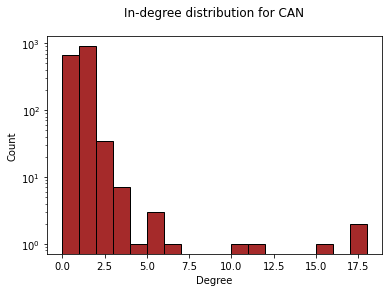

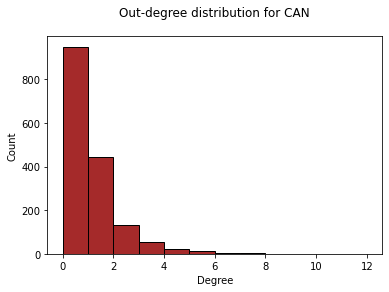

In [87]:
plt.title("In-degree distribution for CAN",pad = 20.0)
plt.hist(in_degree, bins = np.arange(np.min(in_degree), np.max(in_degree)+2),color = 'brown',edgecolor = 'k')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.yscale('log')
plt.show()

plt.title("Out-degree distribution for CAN",pad = 20.0)
plt.hist(out_degree, bins = np.arange(np.min(out_degree), np.max(out_degree)+2),color = 'brown',edgecolor = 'k')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()


In-degree distribution plotted using a log scale for the y axis.

In [47]:
dict_in_degree = dict(G.in_degree(G.nodes))
print("Top most in-degree connected users: ,", sorted(dict_in_degree, key=dict_in_degree.get, reverse=True)[:20])
dict_out_degree = dict(G.out_degree(G.nodes))
print("Top most out-degree connected users: ,", sorted(dict_out_degree, key=dict_out_degree.get, reverse=True)[:10])

Top most in-degree connected users: , ['fordnation', 'realDonaldTrump', 'JustinTrudeau', 'YouTube', 'CBCNews', 'jkenney', 'picardonhealth', 'CTVNews', 'globeandmail', 'celliottability', 'CMOH_Alberta', 'JohnTory', 'scoopit', 'WHO', 'torontostar', 'CP24', 'nationalpost', 'V2019N', 'NYGovCuomo', 'CPHO_Canada']
Top most out-degree connected users: , ['joshbotto', 'YellAlleY', 'CityNewsWPG', 'UbysseyCulture', 'lexxierenauu', 'hmstaffinginc', 'Lindor', 'McIntosh_Becky', 'apolloskeeper', 'Tara92889956']


**Visualization of Network**

100%|██████████| 2000/2000 [00:24<00:00, 81.70it/s] 


BarnesHut Approximation  took  9.37  seconds
Repulsion forces  took  13.46  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.70  seconds


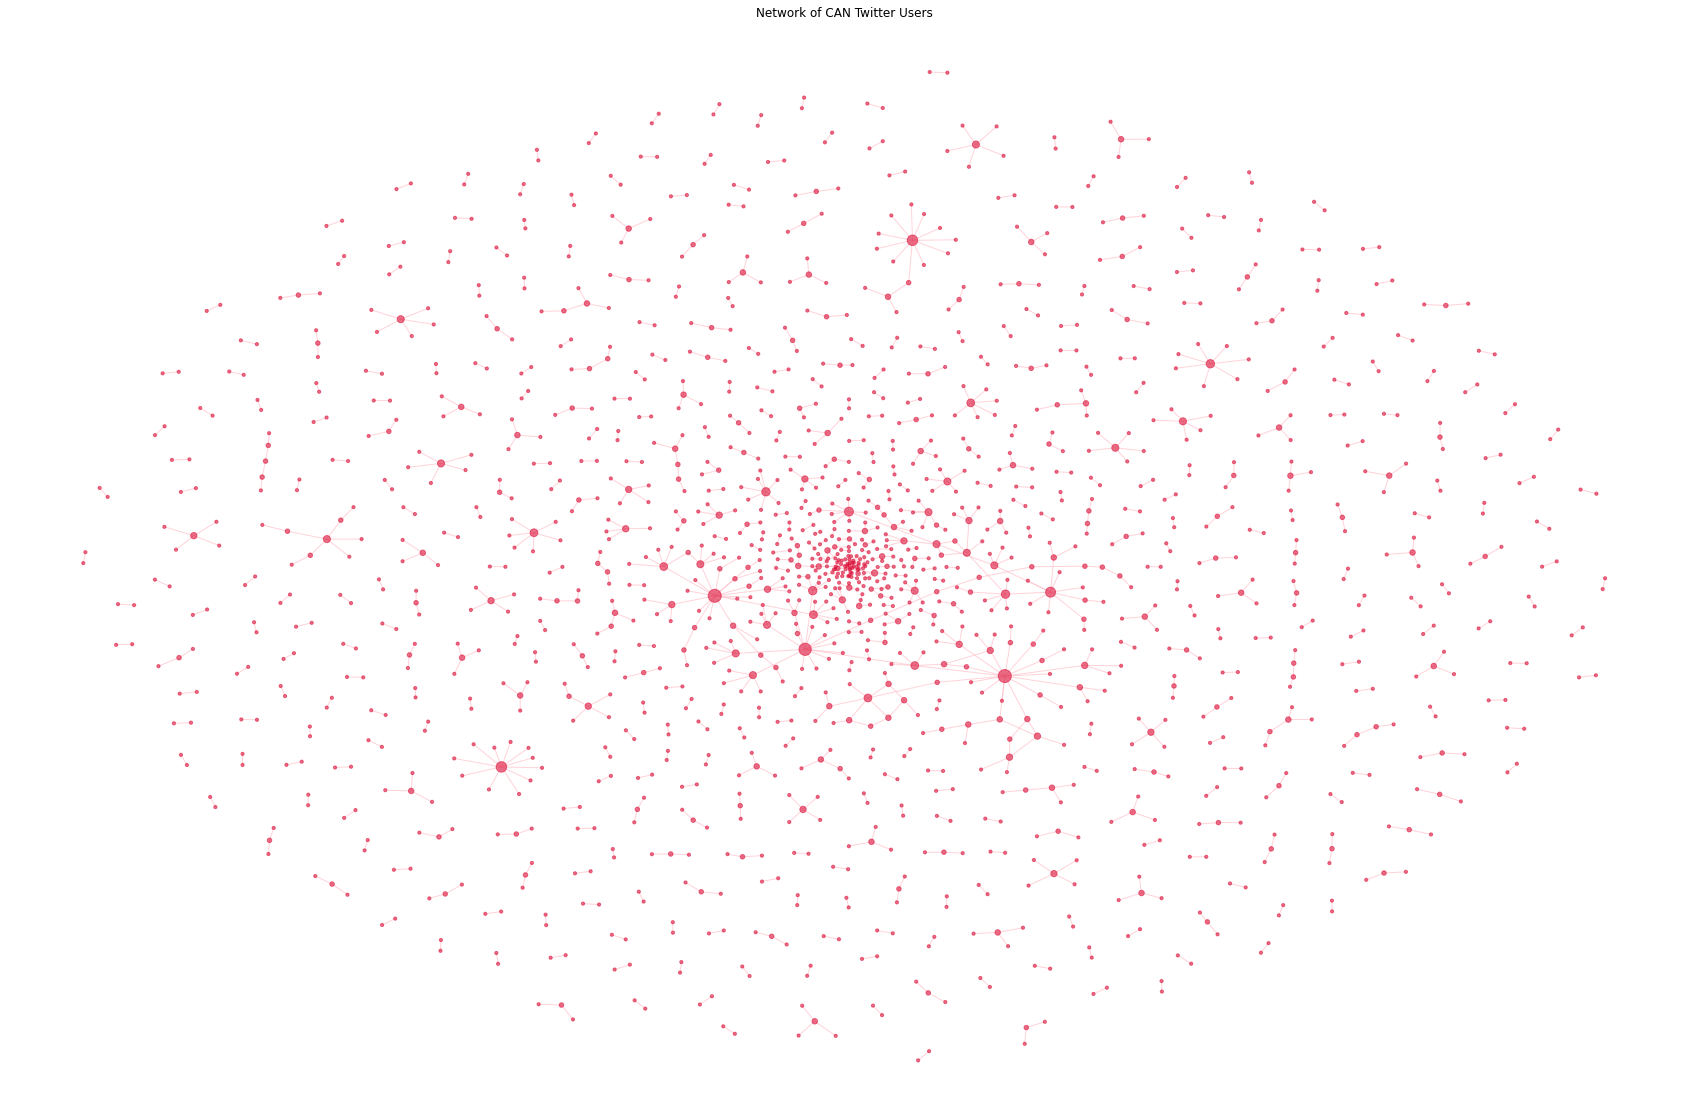

In [51]:
g = G.to_undirected()

# Get in-degrees in dict
degree_dict = dict(g.degree)

plt.figure(figsize = (30,20))

forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False, # Dissuation
                        linLogMode=False,
                        adjustSizes=False, 
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0,  # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(g, pos=None, iterations=2000)

nx.draw_networkx(g, positions,nodelist=degree_dict.keys(), node_size=[v * 10 for v in degree_dict.values()], node_color = "#DC143C",alpha = 0.6, edge_color = '#FFB6C1',with_labels=False)

plt.axis('off')
plt.title('Network of CAN Twitter Users')
plt.show()

# Tweets analysis

Remove links from tweet:

In [52]:
def find_https(tweet):
    tweet =re.sub('\.*amp\.*', '', tweet.lower())
    return re.sub("(http|https)://[\w\-]+(\.[\w\-]+)+\S*",'', tweet)

In [53]:
data_df = data_df_test
data_df['tweet'] = data_df['tweet'].apply(find_https)

In [54]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+') 

def tokenize_tweet(tweet):
    word_tokens = tokenizer.tokenize(tweet)
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words and not w.lower() in ['corona', 'wuhan', 'ncov', 'covid', 'covid_19', 'covid19', 'coronavirus']]
    return filtered_sentence

In [55]:
data_df['tokens'] = data_df['tweet'].apply(tokenize_tweet)

In [56]:
def remove_mentions(x, y):
    for el in y:
        try:
            x.remove(el.lower())
        except:
            pass

In [57]:
data_df.apply(lambda x: remove_mentions(x['tokens'], x['mentions']), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
684    None
685    None
686    None
687    None
688    None
Length: 689, dtype: object

# Identify communities

We use the unsupervised Louvain Algorithm for detecting communities:

In [58]:
partition = community.best_partition(g)

In [59]:
communities = np.unique(list(partition.values()))

The number of communities found is very large, however this was expected given the network also have numerous connections.

In [60]:
## Compute modularity for paritition ##

# Obtain representation of communities for nx_comm.modularity func
comms_dict = {}
for k, v in partition.items():
    str_v_ = str(v)
    if str_v_ not in comms_dict.keys():
        comms_dict[str_v_] = [k]
    else:
        comms_dict[str_v_].append(k)

comms_list = [v for k,v in comms_dict.items()]

M = nx_comm.modularity(g, comms_list)

print('Partition modularity : {}'.format(M))

Partition modularity : 0.9885389836548828


In [61]:
print("Number of found communities:")
print(max(communities))

comm_3_n = [i for i in comms_list if len(i) >=3]

print('Number of communities with more than 3 nodes: {}'.format(len(comm_3_n)))

Number of found communities:
548
Number of communities with more than 3 nodes: 177


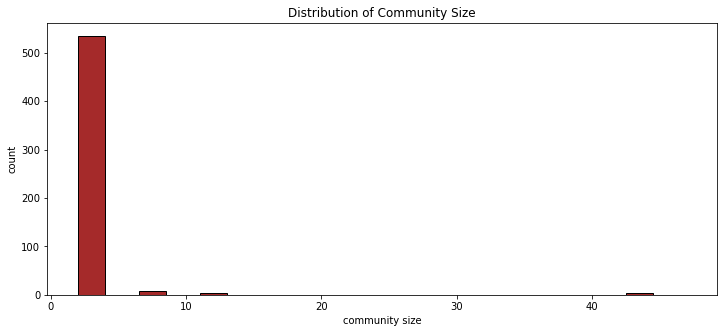

In [86]:
comms_sizes = [len(i) for i in comms_list]

plt.figure(figsize=(12,5))
plt.hist(comms_sizes,width=2,color='brown',edgecolor='k')
plt.xlabel('community size')
plt.ylabel('count')
plt.title('Distribution of Community Size')
plt.show()

In [63]:
d_input = dict(partition.items())
res = {}
for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

Extracting the 10 largest communities only:

In [66]:
count = 0
largest_communities = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:10]
texts = []

for i,t in enumerate(largest_communities):
    texts.append(np.concatenate(data_df.loc[data_df['username'].isin(t[1])]['tokens'].values))
    print(f"Community n. {i+1}. Size: {len(t[1])}")
    count += len(t[1])
    
print(f"\nAround {int(np.round(count/len(g.nodes), 2)*100)}% of network nodes is represented in these partitions.")

Community n. 1. Size: 47
Community n. 2. Size: 46
Community n. 3. Size: 45
Community n. 4. Size: 44
Community n. 5. Size: 15
Community n. 6. Size: 14
Community n. 7. Size: 12
Community n. 8. Size: 9
Community n. 9. Size: 9
Community n. 10. Size: 8

Around 15% of network nodes is represented in these partitions.


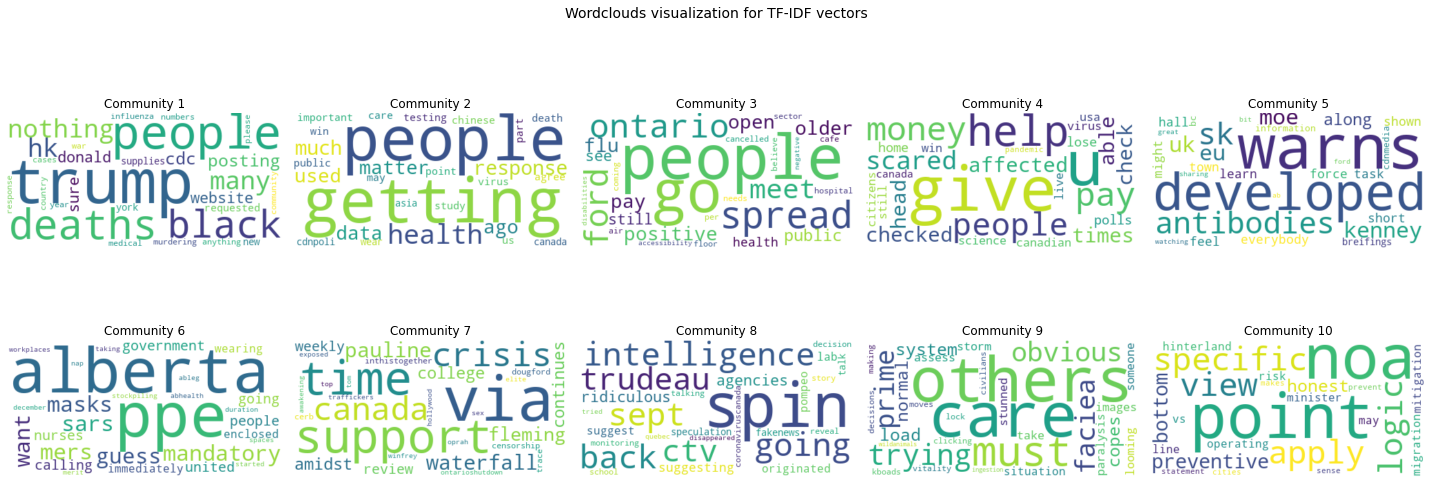

In [67]:
# to calculate the tf:
tf_texts = pd.Series(texts).apply(nltk.FreqDist)

doc_freq = nltk.FreqDist(np.concatenate(pd.Series(texts).apply(lambda x: list(set(x))).values))

idf_values = np.log10((1+21/(1+np.array(list(doc_freq.values()))))) + 1

idf = dict(zip(doc_freq.keys(), idf_values))

def calculate_tf_idf(tf, idf):
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

tf_idf_series = pd.Series(tf_texts).apply(lambda x: calculate_tf_idf(x, idf))

fig, ax = plt.subplots(2, 5, figsize= (20, 8))

c = 0
for i in range(2):
    for j in range(5):
        list_w = sorted(tf_idf_series[c], key=tf_idf_series[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(list_w))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
fig.suptitle("Wordclouds visualization for TF-IDF vectors", fontsize = 14)
fig.tight_layout()
plt.show()

**Visualizing Community in Network**

In [68]:
# Reorganizing partition into dict structure
par_class = set(partition.values())
par_class_dict = {}

for v in partition.values():
    str_v = str(v)
    
    if str_v not in par_class_dict.keys():
        par_class_dict[str_v] = 1
    else:
        par_class_dict[str_v] += 1

In [69]:
# Getting top 10, again
par_class_dict = {k: v for k, v in sorted(par_class_dict.items(), key=lambda item: item[1],reverse = True)}
par_name_top10 = list(par_class_dict.keys())[:10]

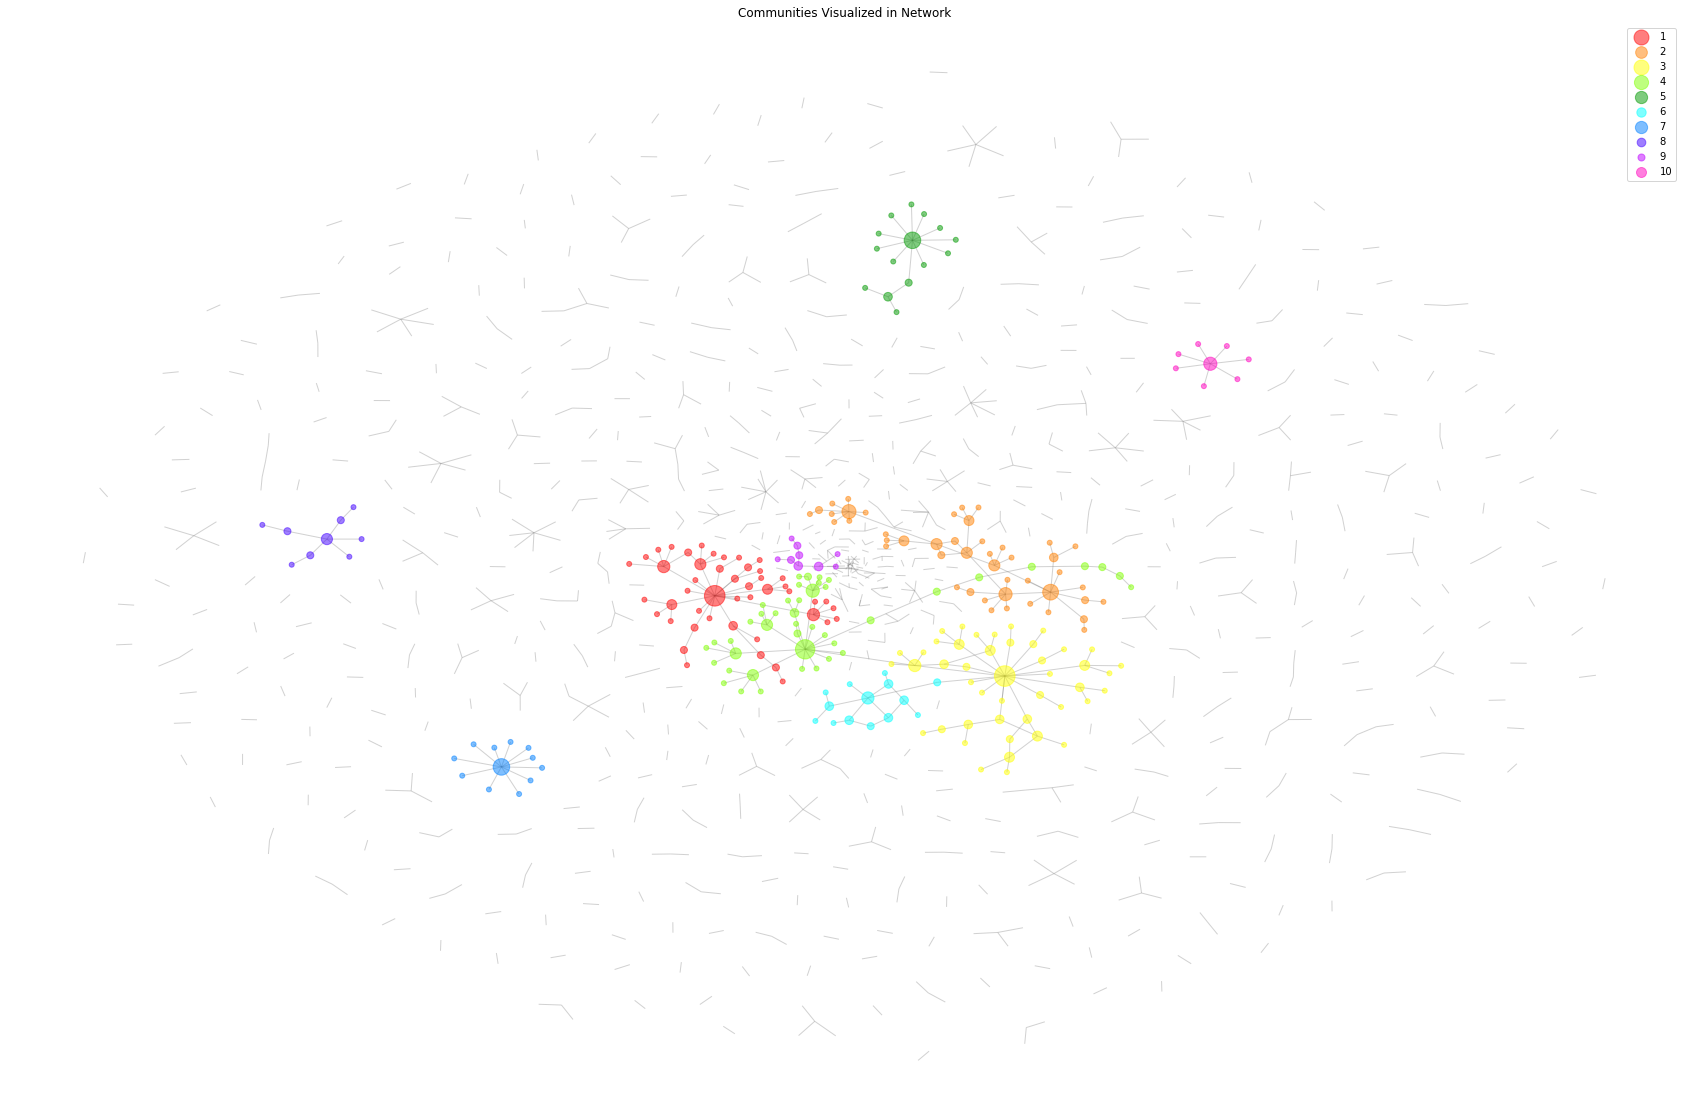

In [70]:
# Plot each community in network
plt.figure(figsize = (30,20))

nx.draw_networkx_edges(g,positions, alpha=0.3, edge_color = 'dimgray')

node_color_list = ['#ff0000','#ff8000','#ffff00','#80ff00',\
                   '#009900','#00ffff','#0080ff','#4000ff',\
                  '#bf00ff','#ff00bf']

for i,par_class in enumerate(par_name_top10):
    nodes = [n for n in list(g.nodes()) if partition[n] == int(par_class)]
    d = dict(g.degree(nodes))
    nx.draw_networkx_nodes(g, positions, d.keys(), node_size=[v*25 for v in d.values()],
                       node_color=node_color_list[i],alpha = 0.5,label =i+1)

plt.legend()   
plt.axis('off')
plt.title("Communities Visualized in Network")
plt.show()   

## Degree Centrality

To investigate degree centrality, we revert back to the directed version of the network graph.

In [71]:
# 5 most central characters according to degree centrality
in_degree_c = nx.in_degree_centrality(G)
out_degree_c = nx.out_degree_centrality(G)

# get the first 5 with in degree centrality
in_degree_c_sorted  = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (in degree centrality):\n{}'.format(in_degree_c_sorted[0:5]))
print('\n')

# get the first 5 with out degree centrality
out_degree_c_sorted  = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central users (out degree centrality):\n{}'.format(out_degree_c_sorted[0:5]))

5 most central users (in degree centrality):
[('fordnation', 0.010493827160493827), ('realDonaldTrump', 0.010493827160493827), ('JustinTrudeau', 0.009259259259259259), ('YouTube', 0.006790123456790123), ('CBCNews', 0.006172839506172839)]


5 most central users (out degree centrality):
[('joshbotto', 0.006790123456790123), ('YellAlleY', 0.0049382716049382715), ('CityNewsWPG', 0.004320987654320987), ('UbysseyCulture', 0.004320987654320987), ('lexxierenauu', 0.004320987654320987)]


In [75]:
def plot_force_directed_graph(Graph, node_size_dict, fivemost_nodes, title_text, node_scale):
    """Make Force Atlas 2 directed graph plot of network with five most central nodes plotted.

        Args:
            Graph (NetworkX Graph object): NetworkX graph to plot.
            node_size_dict (dict): Dictionary of all nodes with value as node size and key for node name.
            fivemost_nodes (dict): Dictionary of five most central nodes with value as node size and key for node name.
            title_text (str): Title for plot.
            node_scale (int): Scaling factor for plotting the nodes.

    """
    
    plt.figure(figsize = (30,20))

    forceatlas2 = ForceAtlas2(
                        ## Behavior alternatives ##
                        outboundAttractionDistribution=False,  # Dissuation
                        linLogMode=False,
                        adjustSizes=False,
                        edgeWeightInfluence=1.0,

                        ## Performance ##
                        jitterTolerance=1.0, # Tolerance level
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,

                        ## Tuning ##
                        scalingRatio=0.1,
                        strongGravityMode=False,
                        gravity=10.0,

                        ## Logging ##
                        verbose=True)

    positions = forceatlas2.forceatlas2_networkx_layout(Graph, pos=None, iterations=2000)
    
    nx.draw_networkx(Graph, positions,nodelist=list(node_size_dict.keys()), node_size=[v * node_scale for v in node_size_dict.values()], alpha = 0.6,\
                        node_color = "#DC143C",edge_color = '#FFB6C1',with_labels=False)
    
    nx.draw_networkx_nodes(Graph, positions, nodelist=list(fivemost_nodes.keys()),node_size=[v * node_scale for v in fivemost_nodes.values()], \
                           alpha = 1, node_color="#DC143C",edgecolors ='black')
    labels = {}
    for node in fivemost_nodes.keys():
        labels[node] = node
    
    nx.draw_networkx_labels(Graph,positions,labels,font_size=18,font_color='k')
    
    plt.title(title_text,fontsize=28)
    plt.axis('off')
    plt.show()

100%|██████████| 2000/2000 [00:25<00:00, 79.09it/s]


BarnesHut Approximation  took  9.73  seconds
Repulsion forces  took  13.94  seconds
Gravitational forces  took  0.15  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.69  seconds


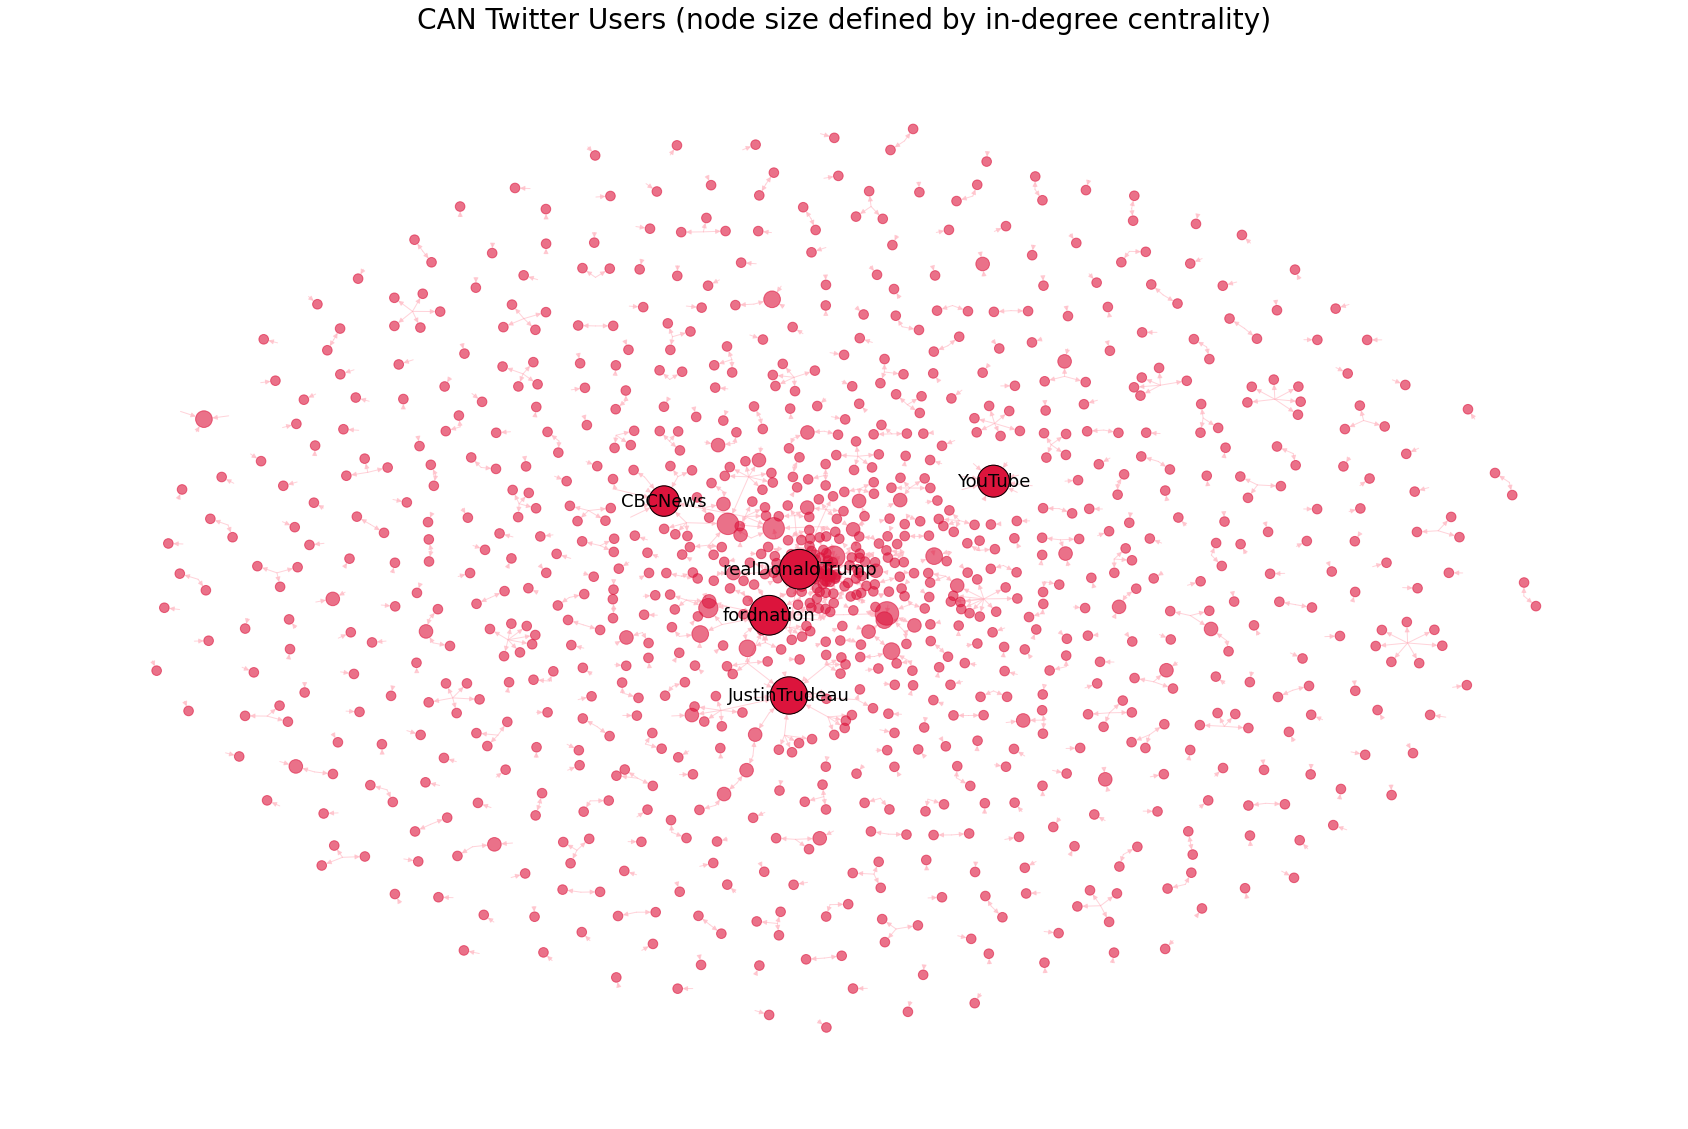

In [76]:
# Plot the network with in-degree centrality
in_degree_c_sorted = sorted(in_degree_c.items(),key = lambda x:x[1],reverse = True)
in_degree_c_sorted = dict(in_degree_c_sorted)
in_degree_c_sorted.update((x, y*10000) for x, y in in_degree_c_sorted.items())

# 5 most central users
nodes_ = list(in_degree_c_sorted)[0:5]
fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = in_degree_c_sorted[i]

title_text = 'CAN Twitter Users (node size defined by in-degree centrality)'

plot_force_directed_graph(G, in_degree_c_sorted,fivemost_nodes,title_text, 15)

100%|██████████| 2000/2000 [00:25<00:00, 78.84it/s]


BarnesHut Approximation  took  9.60  seconds
Repulsion forces  took  14.07  seconds
Gravitational forces  took  0.17  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.72  seconds


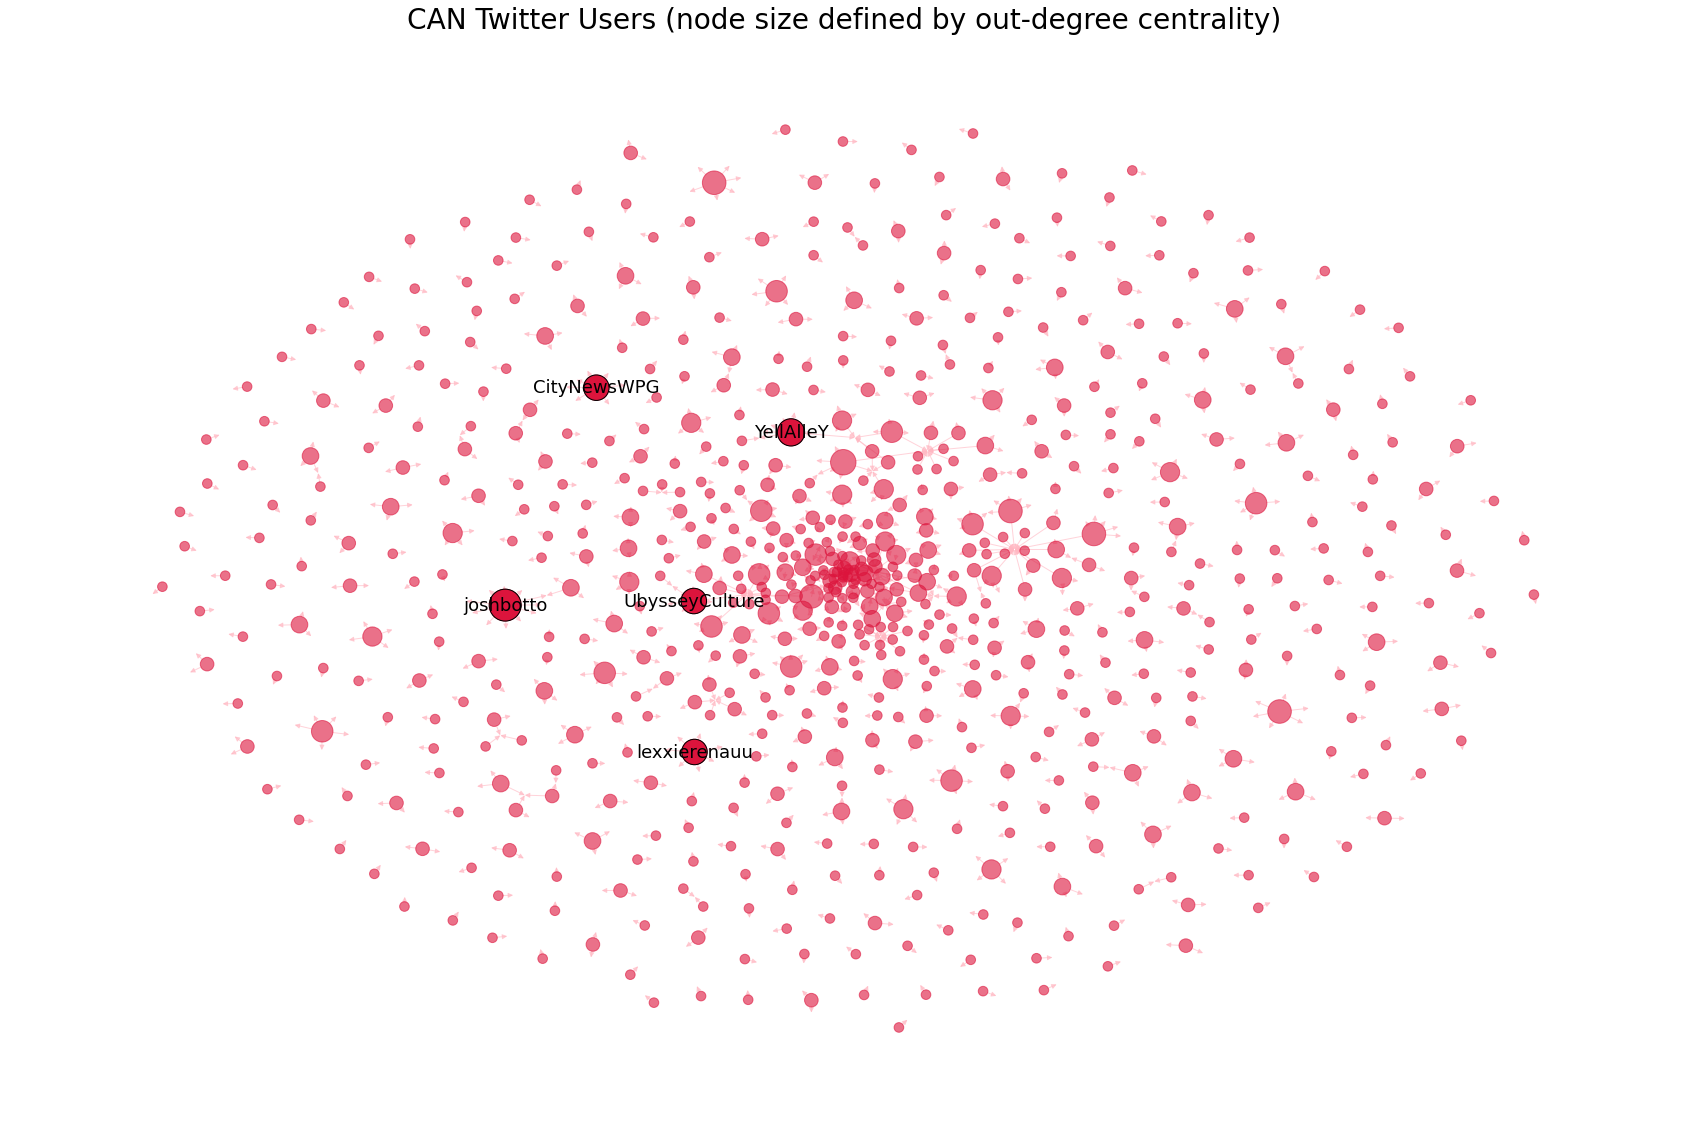

In [78]:
# Plot the network with out-degree centrality
out_degree_c_sorted = sorted(out_degree_c.items(),key = lambda x:x[1],reverse = True)
out_degree_c_sorted = dict(out_degree_c_sorted)
out_degree_c_sorted.update((x, y*10000) for x, y in out_degree_c_sorted.items())

# 5 most central users
nodes_ = list(out_degree_c_sorted)[0:5]

fivemost_nodes = {}
for i in nodes_:
    fivemost_nodes[i] = out_degree_c_sorted[i]

title_text = 'CAN Twitter Users (node size defined by out-degree centrality)'

plot_force_directed_graph(G, out_degree_c_sorted,fivemost_nodes,title_text, 15)

**Betweenness Centrality for Undirected Graph**

In [79]:
between_c = nx.betweenness_centrality(g)

# the 5 most central characters according to betweenness centrality
bet_c_sorted  = sorted(between_c.items(),key = lambda x:x[1],reverse = True)
print('5 most central characters (betweenness centrality):\n{}'.format(bet_c_sorted[0:5]))
print('\n')

5 most central characters (betweenness centrality):
[('fordnation', 0.002820417012991304), ('JustinTrudeau', 0.0025545413645063635), ('Lindor', 0.002086844239064401), ('mr_kruk', 0.0008822699578310037), ('jkenney', 0.0008578683686775102)]




In [80]:
# Scale for better plotting
bet_c_sorted = dict(bet_c_sorted)
bet_c_sorted.update((x, y*100000) for x, y in between_c.items())

100%|██████████| 2000/2000 [00:25<00:00, 78.11it/s] 


BarnesHut Approximation  took  9.90  seconds
Repulsion forces  took  14.01  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  0.04  seconds
AdjustSpeedAndApplyForces step  took  0.71  seconds


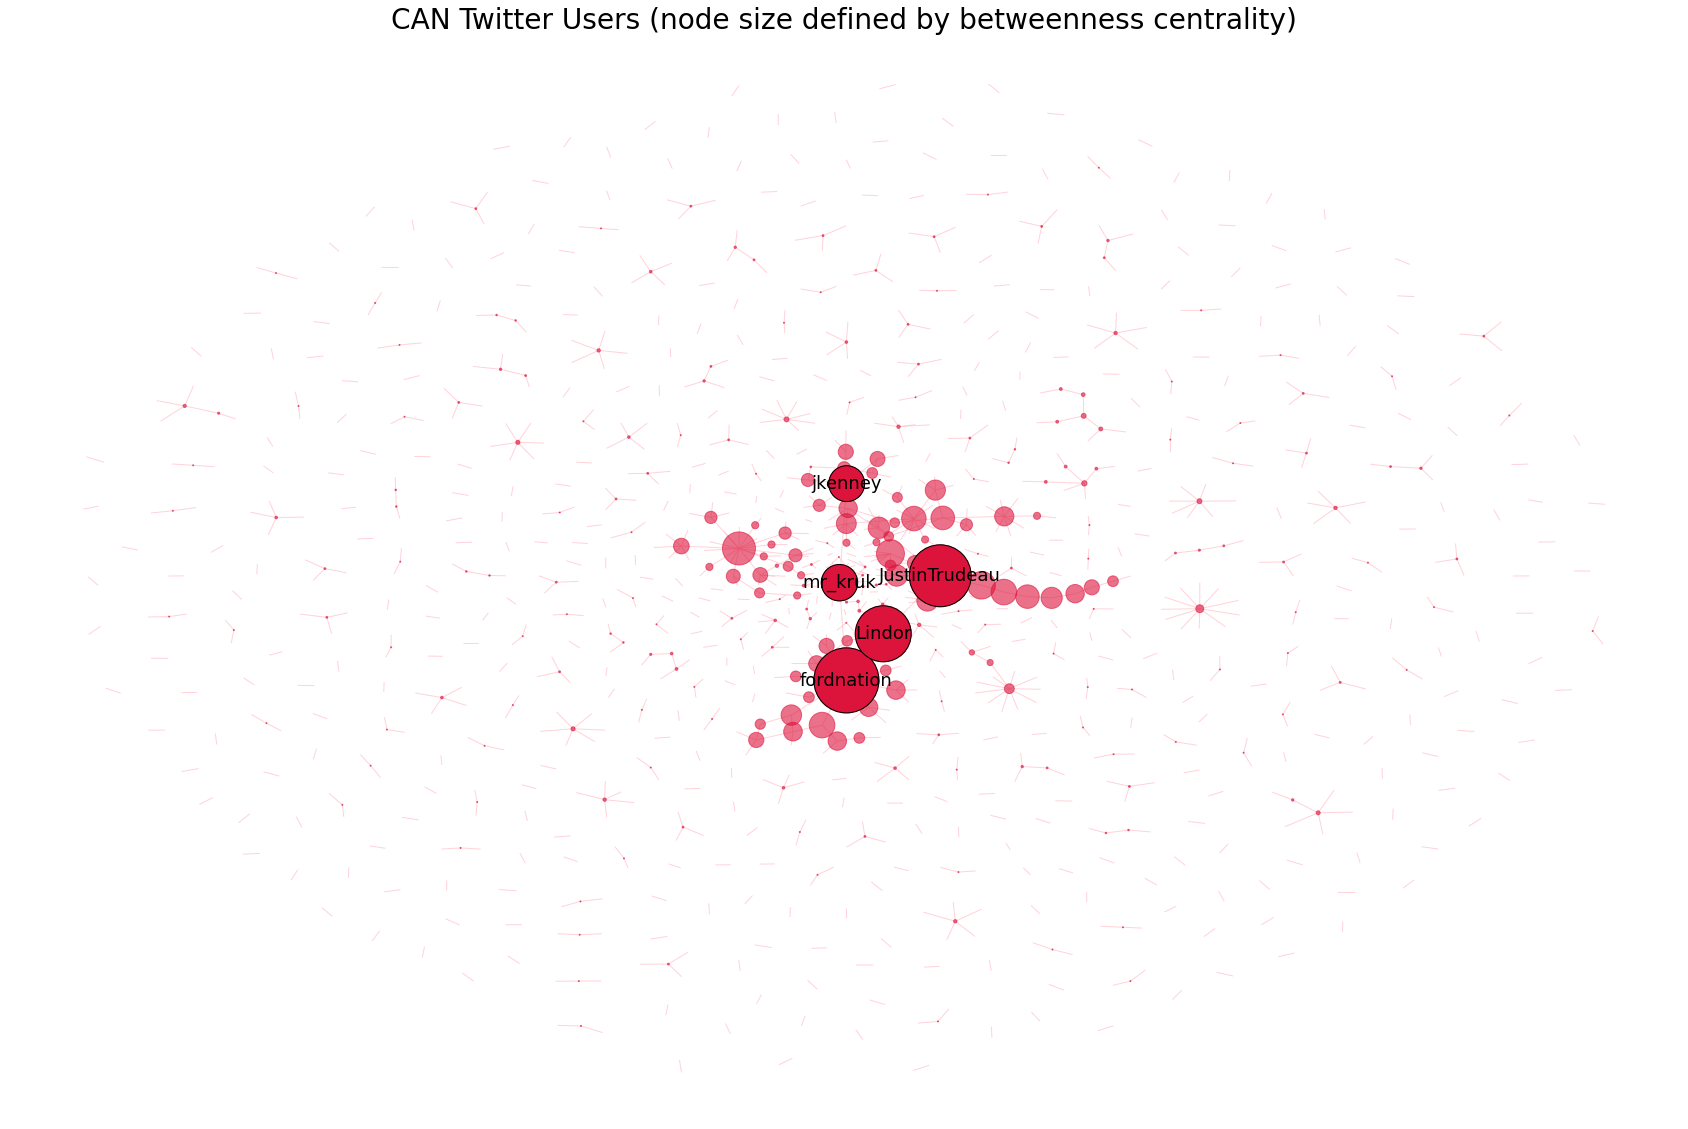

In [81]:
# 5 most central users
nodes_ = list(bet_c_sorted)[0:5]
fivemost_nodes = {}

for i in nodes_:
    fivemost_nodes[i] = bet_c_sorted[i]

plot_force_directed_graph(g, bet_c_sorted, fivemost_nodes,\
                          'CAN Twitter Users (node size defined by betweenness centrality)', 15)

**How are nodes linked?**

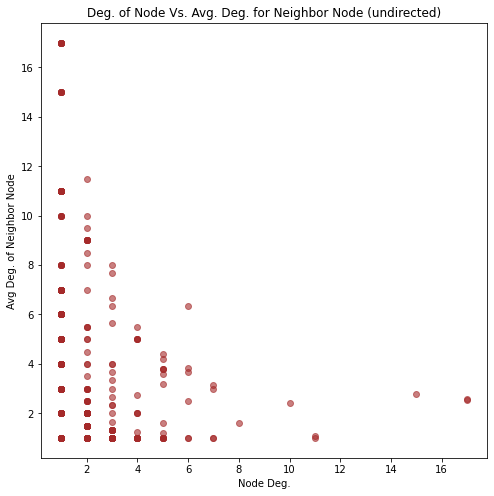

In [85]:
# undirected marvel network
avg_neigh_degrees = nx.average_neighbor_degree(g)

# plot
plt.figure(figsize=(8,8))
plt.scatter(dict(g.degree()).values(),avg_neigh_degrees.values(),c= 'brown',alpha=0.6)
plt.title('Deg. of Node Vs. Avg. Deg. for Neighbor Node (undirected)')
plt.xlabel('Node Deg.')
plt.ylabel('Avg Deg. of Neighbor Node')
plt.show()